# Pipeline

## Imports

In [1]:
import os
import tensorflow as tf
import random
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix, mean_absolute_error
import seaborn as sn
import matplotlib.pyplot as plt
import json

from preprocessing import preprocess
from dataset import make_dataset
from scaling import get_train_mean_std
from model import CRNN
from util import *

## Paths

In [2]:
DATA_DIR = "../../data/"
TRAIN_DIR = "train-clean-360/LibriSpeech/train-clean-360/"
VALID_DIR = "dev-clean/LibriSpeech/dev-clean/"
TEST_DIR = "test-clean/LibriSpeech/test-clean/"
NOISE_DIR = "noise/"
MODEL_DIR = "../models/"
IMAGE_DIR = "../images/"

PROCESSED_DIR = os.path.join(DATA_DIR, "processed/")
DATASET_DIR = os.path.join(DATA_DIR, "dataset/")
BEST_MODEL = os.path.join(MODEL_DIR, "best_weights.h5")
SCALING_FILE = os.path.join(DATA_DIR, "scaling_parameters.json")

## Parameters

#### Dataset Paraameters

In [3]:
initial_s = 10
s = 5
max_k = 10
sample_rate = 16000
preprocessing = False
create_dataset = False
train = False
test = True
samples = [1820, 520, 520]
datasets = ["train", "valid", "test"]

#### Training Parameters

In [4]:
lr = 1e-3
epochs = 1
batch_size = 32

## Model Directory

In [5]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

## Weights & Biases

In [6]:
if train:
  wandb.init(project="test-project", entity="speaker-estimation")
  wandb.config = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size
  }

## Preprocessing

In [7]:
if preprocessing:
    input_dirs = [TRAIN_DIR, VALID_DIR, TEST_DIR]

    for i, dataset in enumerate(datasets):
        print(f"Processing {dataset} set")

        input_dir = os.path.join(DATA_DIR, input_dirs[i])
        output_dir = os.path.join(PROCESSED_DIR, f"{dataset}/")

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        preprocess(input_dir, output_dir, initial_s)

## Creating Dataset

In [8]:
if create_dataset:
    for i, dataset in enumerate(datasets):
        train = True

        print(f"Processing {dataset} set")

        input_dir = os.path.join(PROCESSED_DIR, f"{dataset}/")
        output_dir = os.path.join(DATASET_DIR, f"{dataset}/")

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        if dataset != "train":
            train = False
            
        make_dataset(input_dir, output_dir, max_k, samples[i], train)


## Add Noise for k = 0

In [9]:
if create_dataset:
    noise_files = get_files(os.path.join(DATA_DIR, NOISE_DIR, "audio/"), ".wav")

    speech_categories = ["cafe/restaurant", "grocery_store", "metro_station"]
    noise_files = remove_speech_noise(noise_files, os.path.join(DATA_DIR, NOISE_DIR, "meta.txt"), speech_categories)

    for i, n_samples in enumerate(samples):
        print(f"Processing {datasets[i]} set")
        
        # Select same number of noise samples as 
        # k speaker samples in each dataset
        noise_samples = random.sample(noise_files, n_samples)

        # Remove used samples
        [noise_files.remove(n) for n in noise_samples]

        # Downsample and save noise in dataset directories
        process_noise(DATASET_DIR, datasets[i], noise_samples, sample_rate)


## Compute Train Set Mean and Standard Deviation

In [10]:
if train:
    mean, std = get_train_mean_std(os.path.join(DATASET_DIR, "train/"))

    scaling_parameters = {"mean": float(mean),
                          "std": float(std)}

    with open(SCALING_FILE, 'w') as f:
        json.dump(scaling_parameters, f)

In [11]:
if test:
    with open(SCALING_FILE, 'r') as f:
        scaling_parameters = json.load(f)

    mean = scaling_parameters["mean"]
    std = scaling_parameters["std"]

In [12]:
print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Dataset mean: 0.0007900168420746922
Dataset std: 0.002085912274196744


## Train

### Data Generators

In [13]:
if train:
    train_files = [f for f in os.listdir(os.path.join(DATASET_DIR, "train/")) if f.endswith(".wav")]
    valid_files = [f for f in os.listdir(os.path.join(DATASET_DIR, "valid/")) if f.endswith(".wav")]

In [14]:
if train:
    train_generator = CustomDataGenerator(os.path.join(DATASET_DIR, "train/"), 
                                        train_files, dim=(500, 201), 
                                        max_k=max_k, batch_size=batch_size, 
                                        mean=mean, std=std, 
                                        s=s, train=True, shuffle=True)

    valid_generator = CustomDataGenerator(os.path.join(DATASET_DIR, "valid/"), 
                                    valid_files, dim=(500, 201), 
                                    max_k=max_k, batch_size=1, 
                                    mean=mean, std=std, 
                                    s=s, train=False, shuffle=False)

### Model

In [15]:
model = CRNN((500, 201, 1), max_k)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 199, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 197, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 165, 65, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 163, 63, 128)      36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 161, 61, 64)       73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 20, 64)       0         
 2D)                                                    

### Compile

In [16]:
if train:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=tf.keras.metrics.CategoricalAccuracy(),
    )

### Callbacks

In [17]:
if train:
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'weights.{epoch:02d}-{val_loss:.2f}.h5',),
        save_weights_only=True,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
    )

    wandb_callback = WandbCallback(save_model=False)

### Train

In [18]:
if train:
    model.fit(train_generator, validation_data=valid_generator, epochs=epochs, callbacks=[checkpoint, early_stopping, wandb_callback])
    model.save_weights(os.path.join(MODEL_DIR, 'final_weights.h5'))

## Test

### Data Generator

In [19]:
if test:
    test_files = [f for f in os.listdir(os.path.join(DATASET_DIR, "test/")) if f.endswith(".wav")]

In [20]:
if test:
    test_generator = CustomDataGenerator(os.path.join(DATASET_DIR, "test/"), 
                                    test_files, dim=(500, 201), 
                                    max_k=max_k, batch_size=1, 
                                    mean=mean, std=std, 
                                    s=s, train=False, shuffle=False)

### Get Predictions & Labels

In [21]:
if test:
    model.load_weights(os.path.join(MODEL_DIR, BEST_MODEL))
    predictions = model.predict(test_generator)
    labels = test_generator.get_classes()
    pred = np.argmax(predictions, axis=1)
    true = np.argmax(labels, axis=1)

## Analysis

### Image Directory

In [22]:
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

### Confusion Matrix

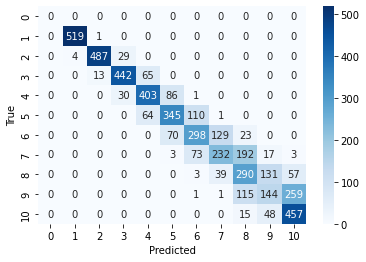

In [23]:
if test:
    cm = confusion_matrix(true, pred, labels=np.arange(max_k+1))
    sn.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.savefig(os.path.join(IMAGE_DIR, "confusion_matrix.png"))
    plt.show()

## Mean Absolute Error

In [24]:
if test:
    mae_scores = []
    for i in range(1,max_k+1):
        mae = mean_absolute_error(true[true == i], pred[true == i])
        mae_scores.append(mae)

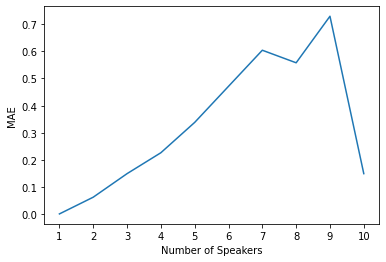

In [25]:
if test:
    plt.plot(np.arange(1,max_k+1), mae_scores)
    plt.xlabel("Number of Speakers")
    plt.ylabel("MAE")
    plt.xticks(np.arange(1,max_k+1))
    plt.savefig(os.path.join(IMAGE_DIR, "mae.png"))
    plt.show()

## Plot Speech Signal and STFT

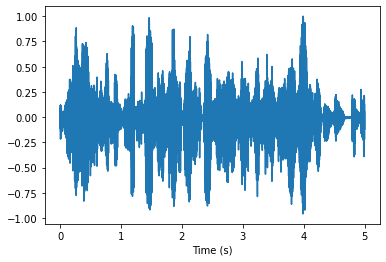

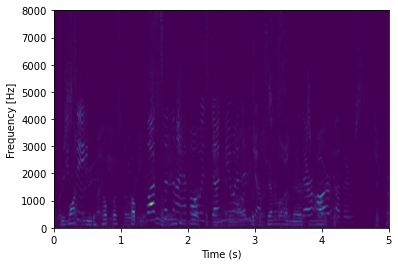

In [26]:
if test:
    # Select random 3 speaker file
    speaker_files = [f for f in test_files if f.startswith("03")]
    file_name = random.choice(speaker_files)
    audio, sample_rate = sf.read(os.path.join(DATASET_DIR, "test/", file_name))
    audio = select_audio(audio, sample_rate, s)

    # Plot and save signal
    plot_signal(audio, sample_rate)
    plt.savefig(os.path.join(IMAGE_DIR, "signal.png"))

    # Plot and save STFT
    plot_stft(audio, sample_rate)
    plt.savefig(os.path.join(IMAGE_DIR, "stft.png"))
 